## Step 2: Random Forests
The targets of our analysis are the **maximum generation** reached by a BBH system, and the evolution of the **remnant spin**, since we already know that the remnant mass is $0.9 (M_1 + M_2)$ of the previous generation.

## Maximum generations
First thing first we check if it is possible to predict the maximum generation reached by each BBH from the initial conditions - i.e. from the data of the second generation of each BBH.

To do so we employ the RandomForestClassifier class from the scikit-learn python package. Since we know there are fewer and fewer samples for greater generations, we group together all generations above the third one in a single class. Furthermore, we define a new feature in the dataset called `DV` which is $v_{escape} - v_{kick}$: we know that if the latter is greater than the former the remnant BH is ejected from its cluster, thus being unable to evolve further, hence we expect it to be important.

We begin the analysis with the NSCs, since we know they reach older generations.

In [2]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, ConnectionPatch
from funky import extractor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, LearningCurveDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

np.set_printoptions(formatter={'float_kind':"{:.2f}".format})

In [3]:
# Setup dataframes

# columns = ['ID', 'M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed','kick','Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen', 'Z', 'max_gen', 'DV']
df_gc = extractor('gc')
df_nsc = extractor('nsc')
df_ysc = extractor('ysc')

In [4]:
# Helper function to better define the method's target classes

def classes(gen):
    if gen > 3: return 2
    return gen - 2  # In this way we should be able to correctly cycle through colors later on

In [5]:
# selecting initial conditions and removing undesired features from the dataframe

first_gen = df_nsc[df_nsc['gen'] == 2]
dumped_features = ['ID', 'gen', 'max_gen']

# splitting data in training and test set
x_train, x_test, y_train, y_test = train_test_split((train_feats := first_gen.drop(columns=dumped_features)), first_gen['max_gen'].transform(classes), test_size=0.2)

# Running the RFC algorithm
forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)

# Printing results
print('Confusion Matrix\n', ['Max gen 2', 'Max gen 3', 'Max gen above 3'], '\n', confusion_matrix(y_test, forest.predict(x_test), normalize='true'))

Confusion Matrix
 ['Max gen 2', 'Max gen 3', 'Max gen above 3'] 
 [[1.00 0.00 0.00]
 [0.00 0.66 0.34]
 [0.00 0.37 0.63]]


From the scores we can clearly appreciate that the forest is perfectly able to classify BBHs that stop at the second generation, but it is not so sure about the remaining classes.

By the importance graph below, we infer that the main and practically only interesting feature to do the job is the $v_{escape} - v_{kick}$ feature, hinting that is not possible to predict the maximum generation from the initial conditions only.

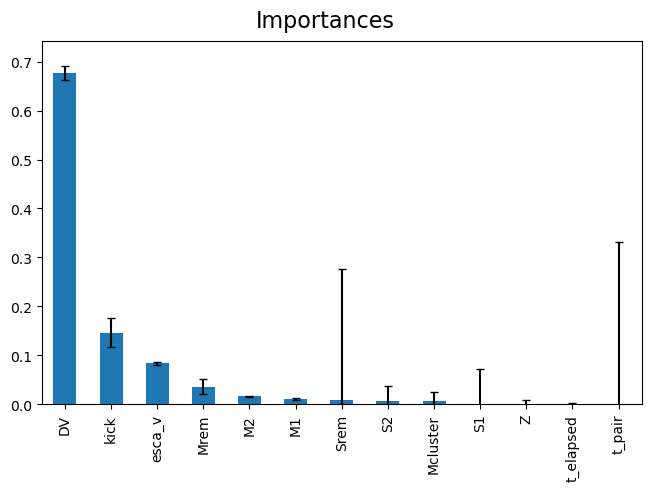

In [6]:
# Plotting importances

fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

#### GC & YSC
Given the previous results, we expect the model to behave in the same way for GCs and YSCs, so we just run the forest prediction, and calculate the confusion matrix over the corresponding whole datasets.

In [7]:
# GCs

gc_first_gen = df_gc[df_gc['gen'] == 2]
gc_test = gc_first_gen.drop(columns=dumped_features)

print(gc_first_gen.groupby('max_gen').size(), '\n\nConfusion Matrix\n', ['Max gen 2', 'Max gen 3', 'Max gen above 3'])
print(confusion_matrix((target_gc := gc_first_gen['max_gen'].transform(classes)), forest.predict(gc_test), normalize='true'))

max_gen
2    422018
3      5500
4       178
5        15
6         3
dtype: int64 

Confusion Matrix
 ['Max gen 2', 'Max gen 3', 'Max gen above 3']
[[1.00 0.00 0.00]
 [0.00 0.96 0.04]
 [0.00 0.90 0.10]]


In [8]:
# YSCs

ysc_first_gen = df_ysc[df_ysc['gen'] == 2]
ysc_test = ysc_first_gen.drop(columns=dumped_features)

print(ysc_first_gen.groupby('max_gen').size(), '\n\nConfusion Matrix\n', ['Max gen 2', 'Max gen 3'])
print(confusion_matrix((target_ysc := ysc_first_gen['max_gen'].transform(classes)), forest.predict(ysc_test), normalize='true'))

max_gen
2    7143
3      32
dtype: int64 

Confusion Matrix
 ['Max gen 2', 'Max gen 3']
[[0.87 0.13]
 [0.00 1.00]]


We notice that the YSCs scores are not perfect, even though the BBHs stop merging at the third generation. We actually expect this to be true for the other types of clusters too, since the results are approximated to have a better look at them. We attribute this uncertainty to the remnants with $v_{escape} \simeq v_{kick}$.

To visualize the accuracy of the forest we plot the decision boundaries of the two most important features in the feature space calculated by the method, along with the test points. The plot clearly shows the struggle of trying to classify points different from the escaped ones.

/home/teobaldo/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


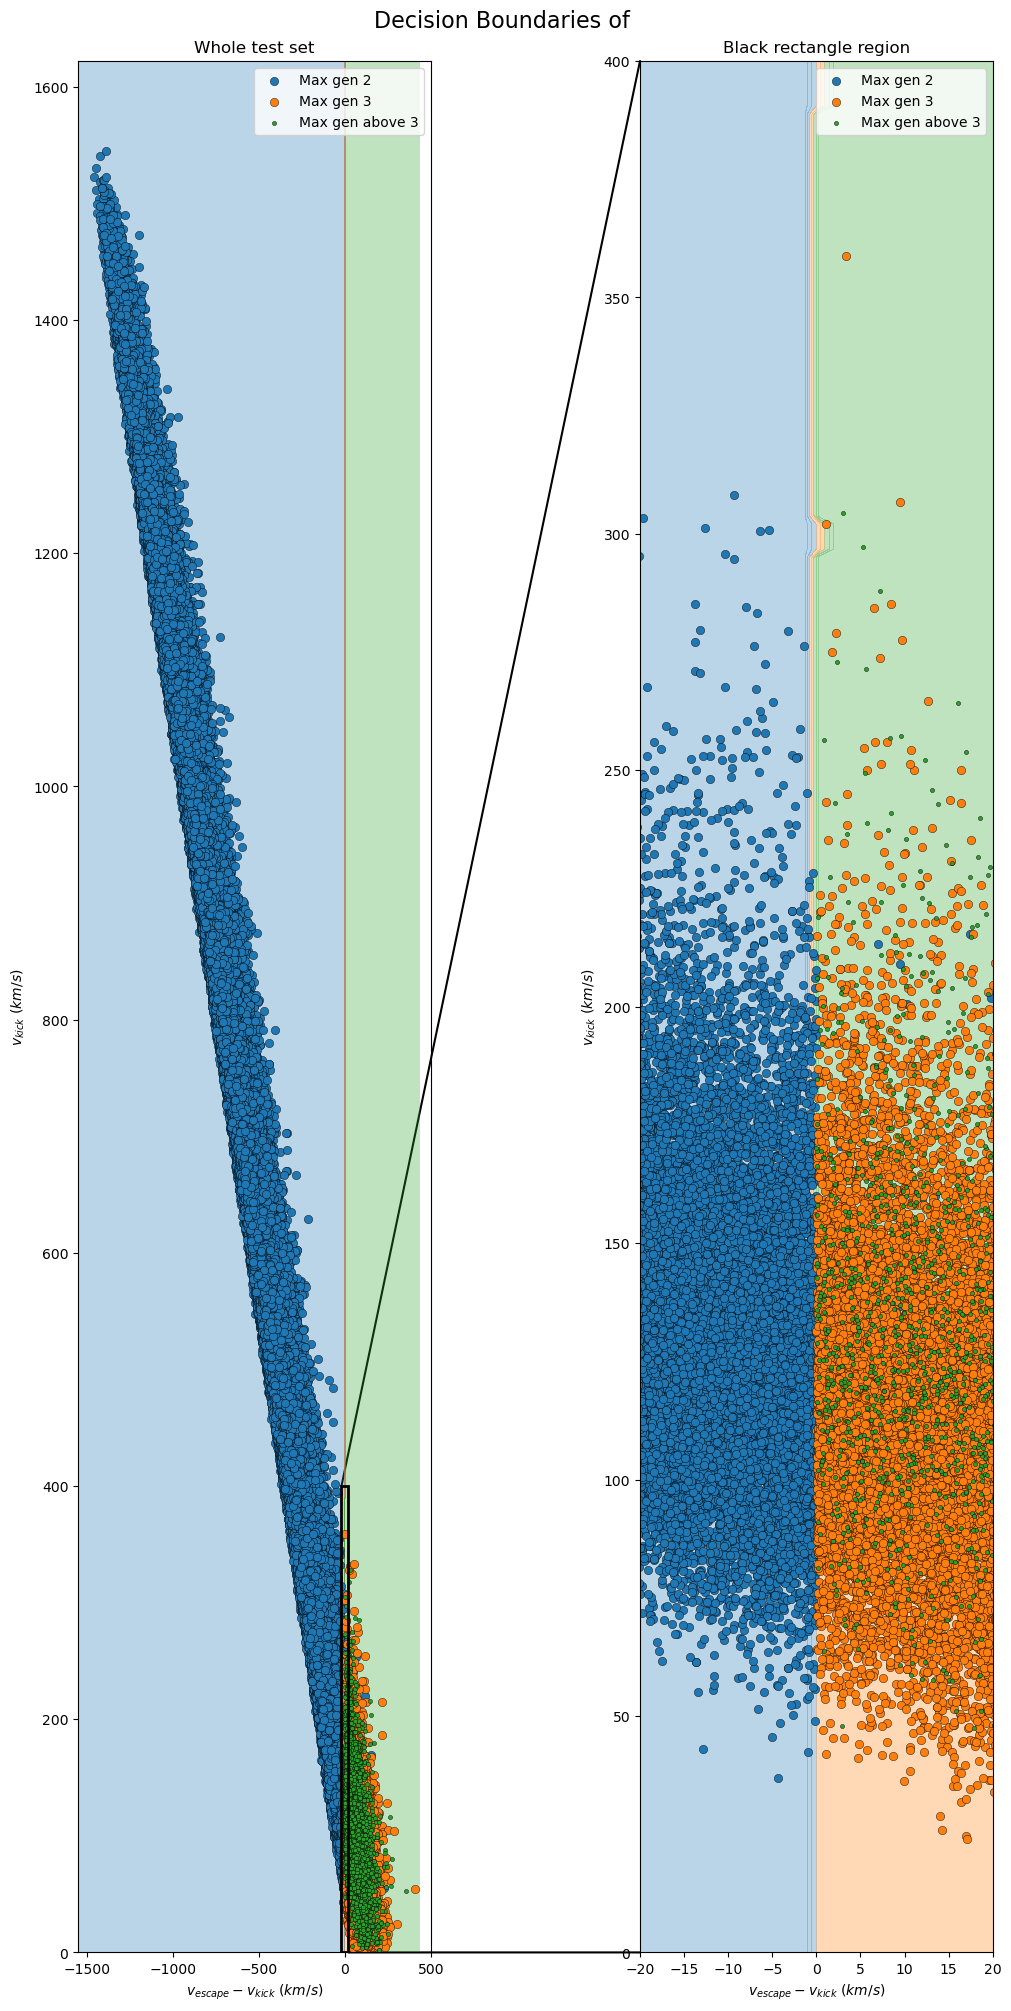

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,6), layout='constrained')
fig.suptitle('Decision Boundaries of ', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(x_train['DV'].min() - 100, x_train['DV'].max() + 100, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

for target, color, label, marker in zip(y_test.unique(), ['tab:blue', 'tab:orange', 'tab:green'], ['Max gen 2', 'Max gen 3', 'Max gen above 3'], ['o', 'o', '.']):
    idx = y_test[y_test == target].index
    ax[0].scatter(x_test['DV'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
    ax[1].scatter(x_test['DV'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
ax[0].set_xlim(right=500)
ax[0].set_ylim(0)
ax[0].set_title('Whole test set')
ax[0].add_patch(Rectangle([-20, 0], 40, 400, color='k', lw=2, fill=False, zorder=2.03))
ax[0].add_patch(ConnectionPatch([-20, 400], [0, 1], 'data', 'axes fraction', axesA=ax[0], axesB=ax[1], lw=1.5))
ax[0].add_patch(ConnectionPatch([20, 0], [0, 0], 'data', 'axes fraction', axesA=ax[0], axesB=ax[1], lw=1.5))


ax[1].set_xlim(-20, 20)
ax[1].set_ylim(0,400)
ax[1].set_title('Black rectangle region')


for Ax in ax:
    Ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange', 'tab:green']))
    Ax.set_xlabel('$v_{escape} - v_{kick}$ $(km/s)$')
    Ax.set_ylabel('$v_{kick}$ $(km/s)$')
    Ax.legend()
plt.show()

In [15]:
gc_test


,M1,M2,S1,S2,t_pair,t_elapsed,kick,Mrem,Srem,esca_v,Mcluster,Z,DV
0,42.863267,12.057043,0.717502,0.149036,307.174987,6681.040018,762.148609,52.533725,0.842818,67.002057,2.189381e+06,0.0120,-695.146552
1,30.956327,27.832721,0.737173,0.109740,77.422376,925.768398,275.499104,54.976925,0.820693,50.580621,6.171573e+05,0.0120,-224.918484
2,28.549238,22.475507,0.728393,0.119595,824.444908,12356.672023,300.375382,47.684799,0.831321,71.501841,2.981196e+06,0.0120,-228.873541
3,66.674765,37.303653,0.735199,0.097003,105.364148,539.236576,137.017515,97.468731,0.849032,52.884473,1.132507e+06,0.0120,-84.133042
4,20.205933,19.630820,0.717912,0.142823,258.262021,7882.005143,185.053115,37.276334,0.814713,47.915447,8.184288e+05,0.0120,-137.137669
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433095,61.062940,50.254873,0.721759,0.220482,17.886734,1989.799126,692.891753,103.827730,0.837561,27.230955,1.650709e+05,0.0016,-665.660798
433096,24.090318,20.155526,0.738974,0.033285,150.621693,1157.701024,1226.389489,41.420960,0.818955,58.367334,9.269867e+05,0.0016,-1168.022155
433097,51.884767,44.706736,0.733724,0.284186,15.705739,65.760224,387.533097,89.924200,0.843628,38.037800,2.353835e+05,0.0016,-349.495297
433098,110.184596,92.483101,0.709351,0.723449,6.087391,17.466905,106.811420,186.381405,0.886330,45.808263,2.822398e+05,0.0016,-61.003156


In [16]:
target_gc

0         0
1         0
2         0
3         0
4         0
         ..
433095    0
433096    0
433097    0
433098    0
433099    0
Name: max_gen, Length: 427714, dtype: int64

/home/teobaldo/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


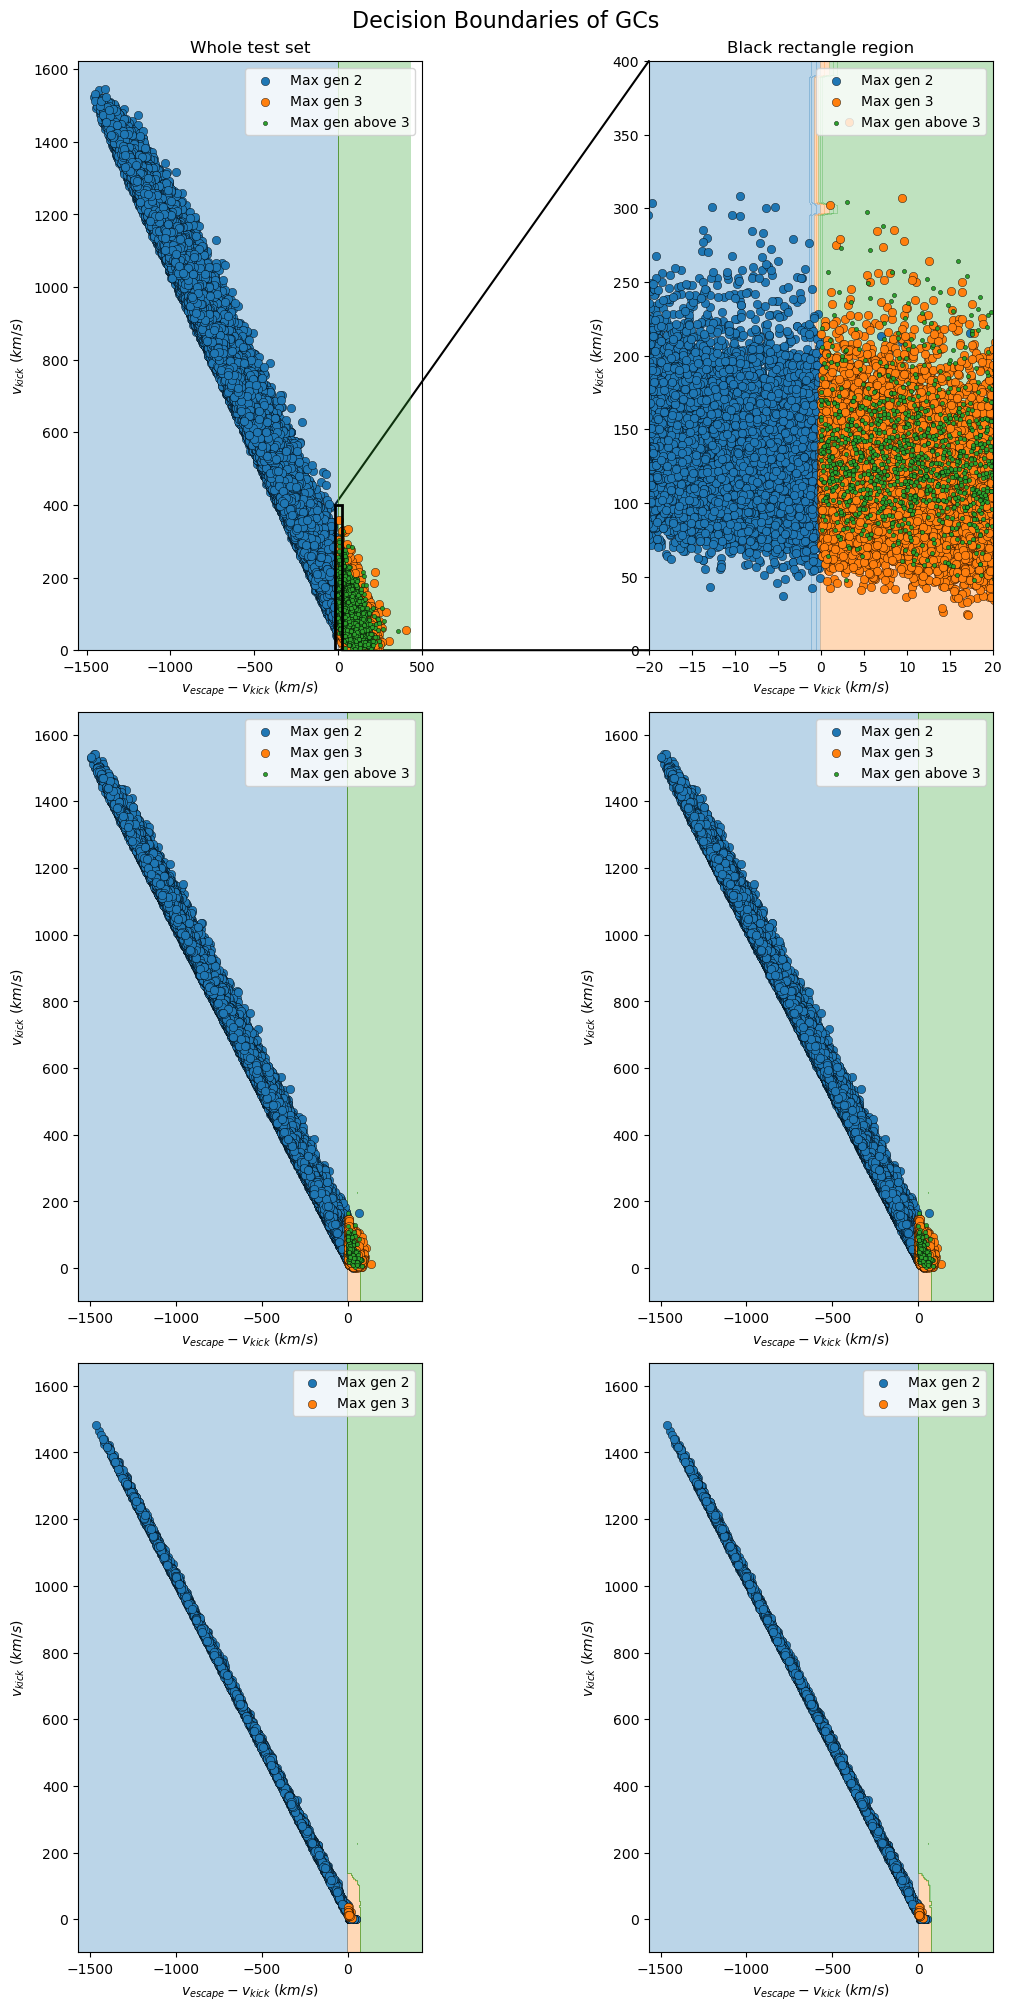

In [19]:
fig, ax = plt.subplots(3,2, figsize=(10,20), layout='constrained')
fig.suptitle('Decision Boundaries', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(x_train['DV'].min() - 100, x_train['DV'].max() + 100, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

for target, color, label, marker in zip(y_test.unique(), ['tab:blue', 'tab:orange', 'tab:green'], ['Max gen 2', 'Max gen 3', 'Max gen above 3'], ['o', 'o', '.']):
    idx = y_test[y_test == target].index
    ax[0,0].scatter(x_test['DV'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
    ax[0,1].scatter(x_test['DV'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
for target, color, label, marker in zip(target_gc.unique(), ['tab:blue', 'tab:orange', 'tab:green'], ['Max gen 2', 'Max gen 3', 'Max gen above 3'], ['o', 'o', '.']):
    idx = target_gc[target_gc == target].index
    ax[1,0].scatter(gc_test['DV'][idx], gc_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
    ax[1,1].scatter(gc_test['DV'][idx], gc_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
for target, color, label in zip(target_ysc.unique(), ['tab:blue', 'tab:orange'], ['Max gen 2', 'Max gen 3']):
    idx = target_ysc[target_ysc == target].index
    ax[2,0].scatter(ysc_test['DV'][idx], ysc_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
    ax[2,1].scatter(ysc_test['DV'][idx], ysc_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
ax[0,0].set_xlim(right=500)
ax[0,0].set_ylim(0)
ax[0,0].set_title('Whole test set')
ax[0,0].add_patch(Rectangle([-20, 0], 40, 400, color='k', lw=2, fill=False, zorder=2.03))
ax[0,0].add_patch(ConnectionPatch([-20, 400], [0, 1], 'data', 'axes fraction', axesA=ax[0,0], axesB=ax[0,1], lw=1.5))
ax[0,0].add_patch(ConnectionPatch([20, 0], [0, 0], 'data', 'axes fraction', axesA=ax[0,0], axesB=ax[0,1], lw=1.5))


ax[0,1].set_xlim(-20, 20)
ax[0,1].set_ylim(0,400)
ax[0,1].set_title('Black rectangle region')





for Ax in ax.ravel():
    Ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange', 'tab:green']))
    Ax.set_xlabel('$v_{escape} - v_{kick}$ $(km/s)$')
    Ax.set_ylabel('$v_{kick}$ $(km/s)$')
    Ax.legend(loc='upper right')



plt.show()

### Dropping escaped BBHs

Acknowledged the escape problem, we focus the method on BBHs which reach generations greater than two. We expect to find the same scores, but the importances will be updated to reflect the issue.

In [10]:
# we run the same algorithm as above, except we drop 'max_gen' == 2

# data preparation
first_gen = df_nsc[df_nsc['gen'] == 2].where(df_nsc['max_gen'] != 2).dropna()
dumped_features = ['ID', 'gen', 'max_gen']
x_train, x_test, y_train, y_test = train_test_split((train_feats := first_gen.drop(columns=dumped_features)), first_gen['max_gen'].transform(classes), test_size=0.2)

# forest run
forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)

# results
print(f'train size: {len(first_gen)}\ntest size: {len(y_test)}')
print(classification_report(y_test, forest.predict(x_test), target_names=['Max gen 3', 'Max gen above 3']))
print(['Max gen 3', 'Max gen above 3'], '\n', confusion_matrix(y_test, forest.predict(x_test), normalize='true'))

train size: 181075
test size: 36215
                 precision    recall  f1-score   support

      Max gen 3       0.94      0.63      0.75     31945
Max gen above 3       0.20      0.68      0.30      4270

       accuracy                           0.63     36215
      macro avg       0.57      0.65      0.53     36215
   weighted avg       0.85      0.63      0.70     36215

['Max gen 3', 'Max gen above 3'] 
 [[0.63 0.37]
 [0.32 0.68]]


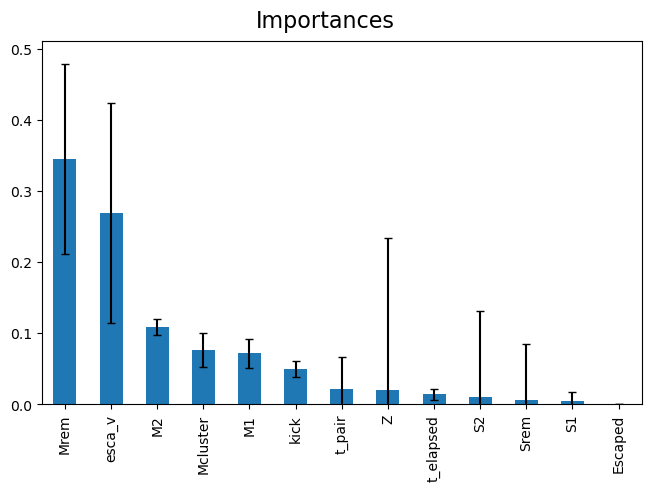

In [8]:
# Plotting importances

fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

/home/teobaldo/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


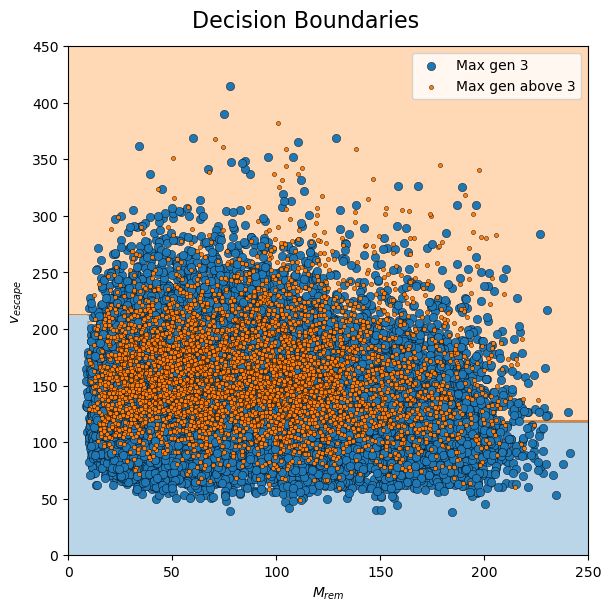

In [9]:
# Plotting boundaries

fig, ax = plt.subplots(figsize=(6,6), layout='constrained')
fig.suptitle('Decision Boundaries', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(x_train['Mrem'].min() - 1000, x_train['Mrem'].max() + 1000, 1000), np.linspace(0, 500, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange']))
for target, color, label, marker in zip(y_test.unique(), ['tab:blue', 'tab:orange'], ['Max gen 3', 'Max gen above 3'], ['o', '.']):
    idx = y_test[y_test == target].index
    ax.scatter(x_test['Mrem'][idx], x_test['esca_v'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
#ax.set_ylim(0,350)


ax.set_ylabel('$v_{escape}$')
ax.set_xlabel('$M_{rem}$')
ax.set_xlim(0, 250)
ax.set_ylim(0, 450)
ax.legend()
plt.show()

### Targeted generation
We expect this behaviour to hold for older generations too, to prove this we run the algorithm over a sample of target generations (for the sake of brevity we only show one of them), and set the objective to its possible evolution.

In [10]:
# data preparation
gen_prec = df_nsc[df_nsc['gen'] == 5]
dumped_features = ['ID', 'gen', 'max_gen']
x_train, x_test, y_train, y_test = train_test_split((train_feats := gen_prec.drop(columns=dumped_features)), gen_prec['max_gen'] > 5, test_size=0.2)

# running forest algorithm
forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
print(f'train size: {len(gen_prec)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 21486
test size: 4298
0.9988366682177757


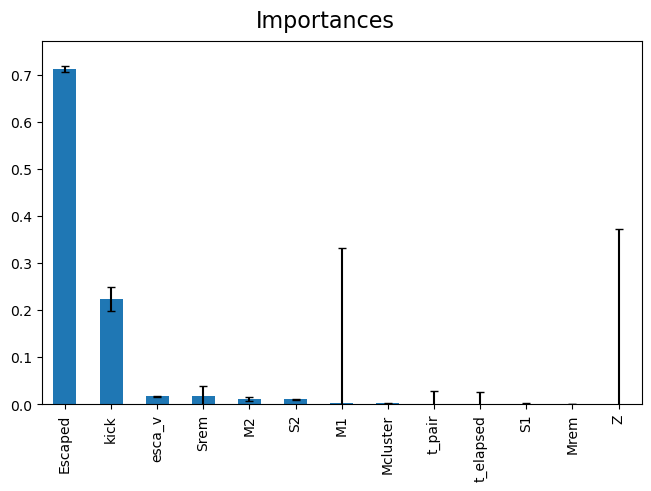

In [11]:
# plot importances

fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

/home/teobaldo/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


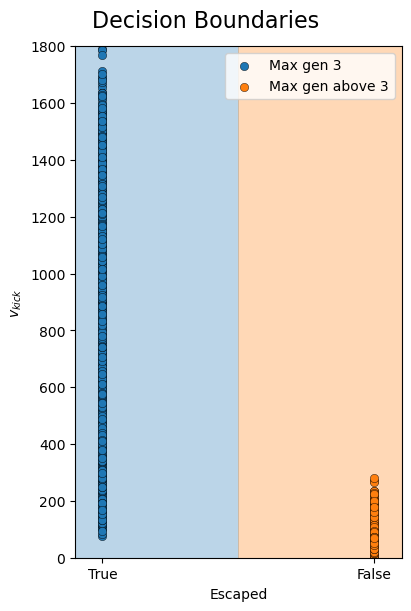

In [12]:
# plot decision boundaries

fig, ax = plt.subplots(figsize=(4,6), layout='constrained')
fig.suptitle('Decision Boundaries', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(-.5, 1.5, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=ListedColormap(['tab:blue', 'tab:orange']))
for target, color, label in zip(y_test.unique(), ['tab:blue', 'tab:orange'], ['Max gen 3', 'Max gen above 3']):
    idx = y_test[y_test == target].index
    ax.scatter(x_test['Escaped'][idx], x_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
#ax.set_ylim(0,350)


ax.set_ylabel('$v_{kick}$')
ax.set_xlabel('Escaped')
ax.set_xlim(-.1, 1.1)
ax.set_ylim(0, 1800)
ax.set_xticks([0,1], [True, False])
ax.legend()
plt.show()

## Spin of the Remnant
Since the spin and the mass of the remnant are continuous features, we implement the RandomForestRegressor class instead.

In [13]:
dumped_features = ['ID', 'Srem', 'max_gen', 'Escaped']

x_train, x_test, y_train, y_test = train_test_split((train_feats := df_nsc.drop(columns=dumped_features)), df_nsc['Srem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=15, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)
print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print(forest.score(x_test, y_test))

train size: 2230650
test size: 557663
0.9781940630649641


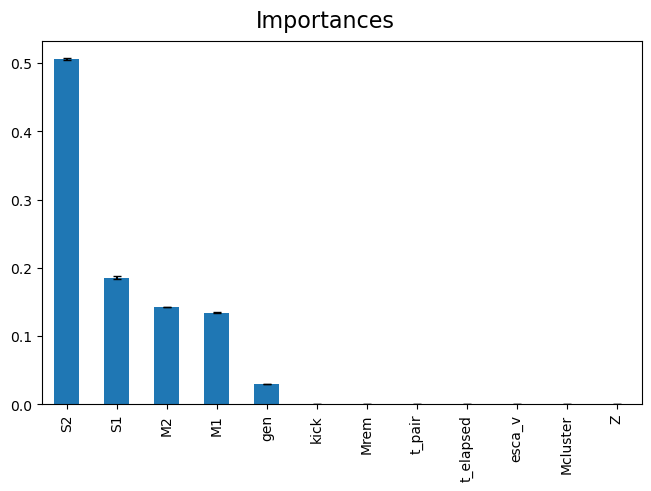

In [14]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

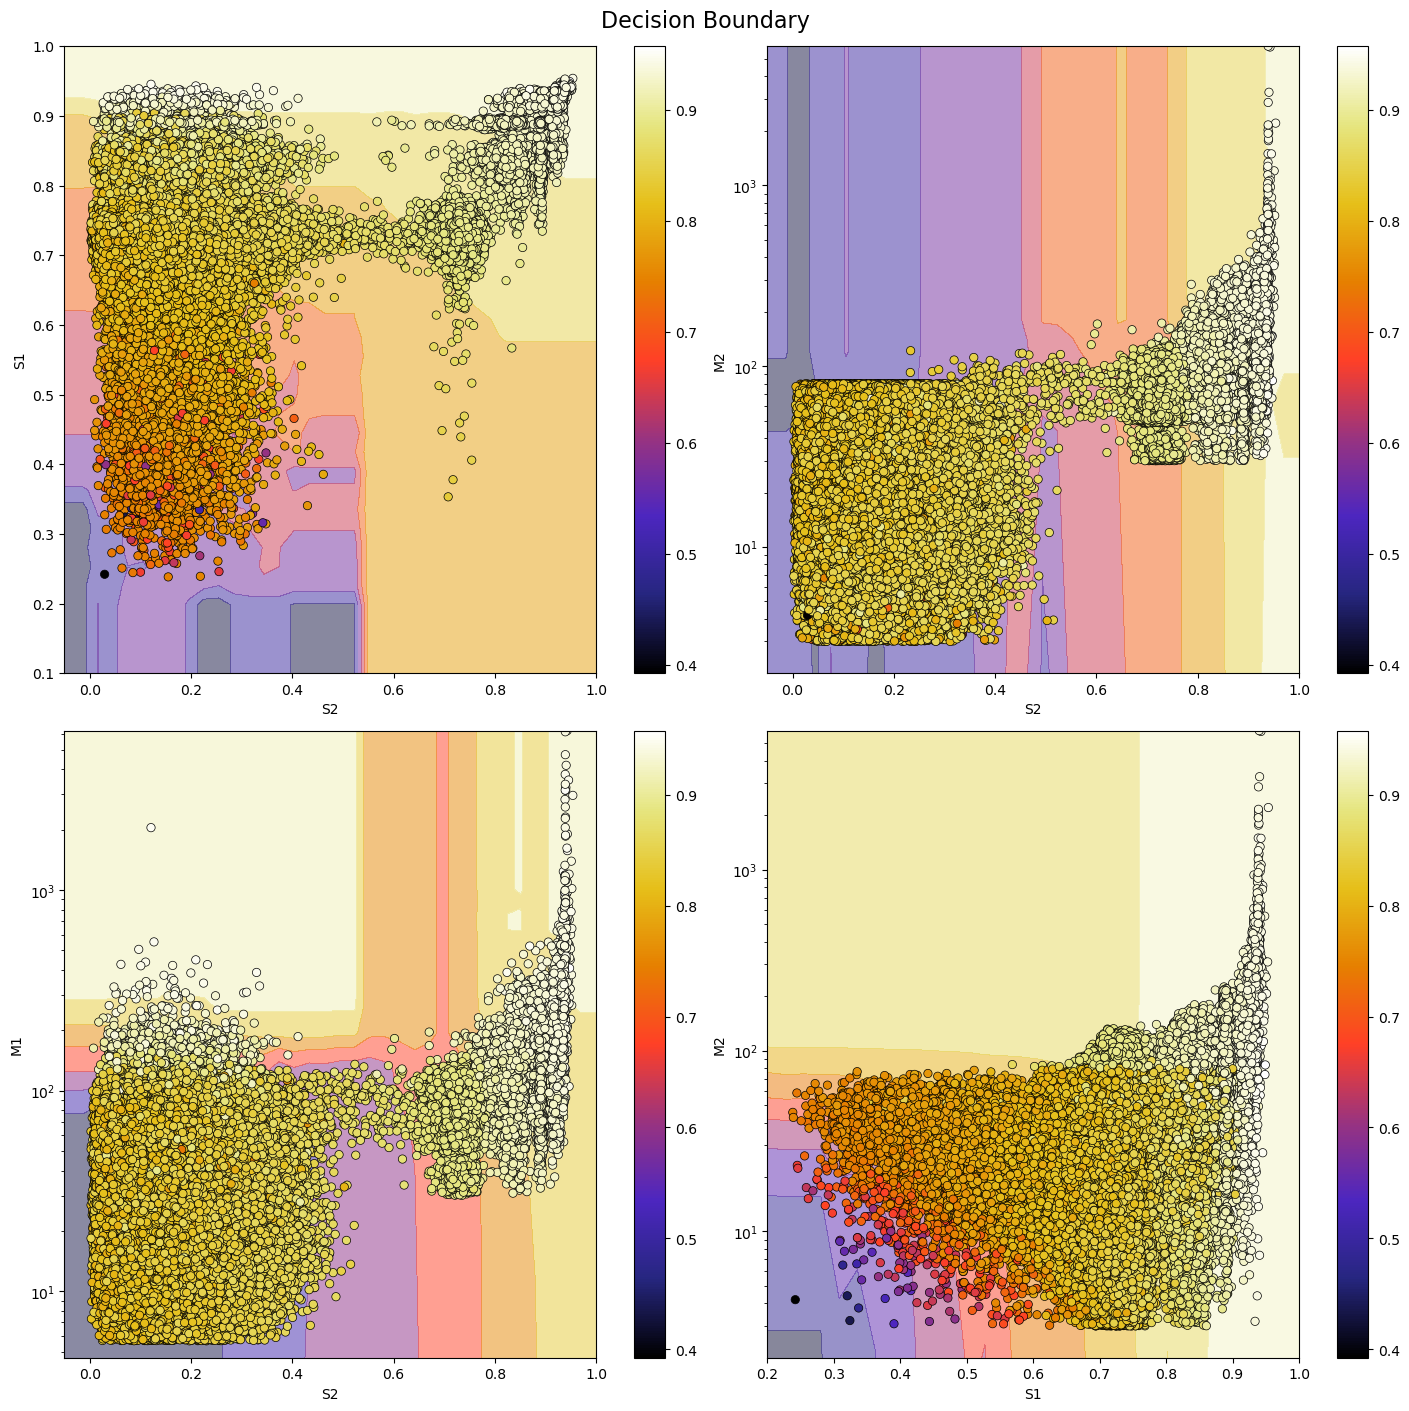

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(14,14), layout='constrained')
fig.suptitle('Decision Boundary', fontsize=16)


forest.fit(x_train[( important_features := list(importances.index[:2]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[0,0])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[0,0].set_xlim(-.05, 1)
ax[0,0].set_ylim(0.1, 1)
fig.colorbar(im)


forest.fit(x_train[( important_features := list(importances.index[[0,2]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[0,1])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[0,1].set_yscale('log')
ax[0,1].set_xlim(-.05, 1)
fig.colorbar(im)


forest.fit(x_train[( important_features := list(importances.index[[0,3]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[1,0])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[1,0].set_yscale('log')
ax[1,0].set_xlim(-.05, 1)
fig.colorbar(im)


forest.fit(x_train[( important_features := list(importances.index[[1,2]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[1,1])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[1,1].set_yscale('log')
ax[1,1].set_xlim(.2, 1)
fig.colorbar(im)

plt.show()